# Variational Autoencoder (VAE)

Useful links:
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

### Download data

In [1]:
import requests
from urllib.parse import urlencode
import os


# based on https://ru.stackoverflow.com/a/1088518
def download_from_yadisk(short_url: str, filename: str, target_dir: str):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

    final_url = base_url + urlencode(dict(public_key=short_url))
    response = requests.get(final_url)
    download_url = response.json()['href']

    download_response = requests.get(download_url)
    target_file = os.path.join(target_dir, filename)
    with open(target_file, 'wb') as f:
        f.write(download_response.content)

In [2]:
#!L
import os

TARGET_DIR = '.'
FILENAME = "celeba.zip"

if not os.path.exists(os.path.join(TARGET_DIR, FILENAME)):
    # we are going to download 1.4 gb file, downloading will take some time (8-10 minutes)
    download_from_yadisk(
        short_url='https://disk.yandex.ru/d/QErNx-MoC-2Y6Q',
        filename=FILENAME,
        target_dir=TARGET_DIR
    )

filesize = os.path.getsize(os.path.join(TARGET_DIR, FILENAME))
GB = 2**30
assert filesize > 1 * GB, "{filesize} is too small, something wrong with downloading"

In [46]:
!unzip celeba.zip

## Prepare the data

In [4]:
#!L
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid

device = torch.device("cuda")

In [5]:
#!L
class CropCelebA64:

    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [6]:
#!L

# Note that for simplicity we reduce the number of channels to 1

train_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),

        torchvision.transforms.Grayscale()
    ]),
)

validation_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='valid',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),

        torchvision.transforms.Grayscale()
    ]),
)

In [7]:
#!L
# Save first 10k images for evaluation
num_images = 10000
real_images_tensor = torch.stack([train_dataset[i][0] for i in range(num_images)], dim=0)
real_images = real_images_tensor.data.numpy().transpose([0, 2, 3, 1])
np.savez("real.npz", Pictures=real_images.reshape(num_images, 64 * 64 * 1))

In [8]:
#!L
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

In [9]:
#!L
dimZ = 128  # Considering face reconstruction task, which size of representation seems reasonable?

# We define the decoder and encoder as networks with one hidden fc-layer
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics

class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential()
        self.decoder = nn.Sequential()

        self.encoder.add_module("flatten", nn.Flatten())
        self.encoder.add_module("linear", nn.Linear(64 * 64, 64 * 16))
        self.encoder.add_module('act1', nn.ReLU())
        self.encoder.add_module("to_latent_code", nn.Linear(64 * 16, dimZ))

        torch.nn.init.xavier_uniform_(self.encoder.linear.weight)
        self.encoder.linear.bias.data.fill_(0.0)
        torch.nn.init.xavier_uniform_(self.encoder.to_latent_code.weight)
        self.encoder.to_latent_code.bias.data.fill_(0.0)

        self.decoder.add_module("linear", nn.Linear(dimZ, 64 * 16))
        self.decoder.add_module('act1', nn.ReLU())
        self.decoder.add_module("to_image", nn.Linear(64 * 16, 64 * 64))
        self.decoder.add_module('normalize', nn.Sigmoid())

        torch.nn.init.xavier_uniform_(self.decoder.linear.weight)
        self.decoder.linear.bias.data.fill_(0.0)
        torch.nn.init.xavier_uniform_(self.decoder.to_image.weight)
        self.decoder.to_image.bias.data.fill_(0.0)

    def forward(self, x):

        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)

        return reconstruction, latent_code

In [10]:
#!L
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder().to(device)

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters())

In [37]:
from IPython import display
from tqdm.auto import tqdm

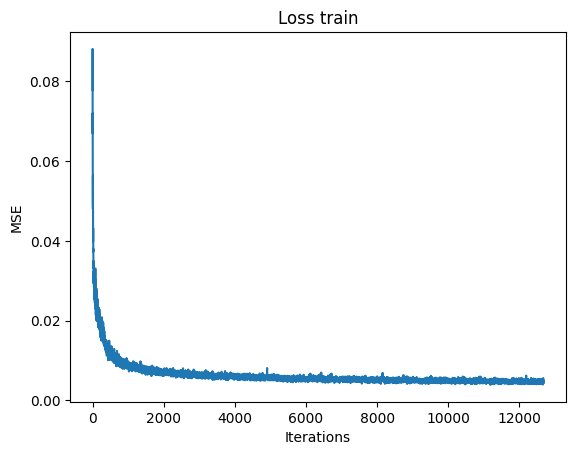

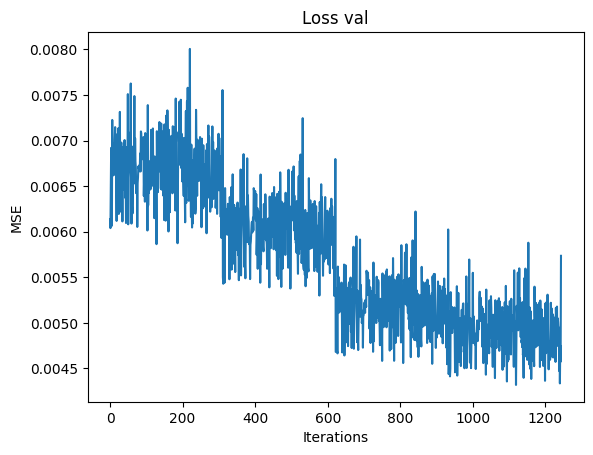

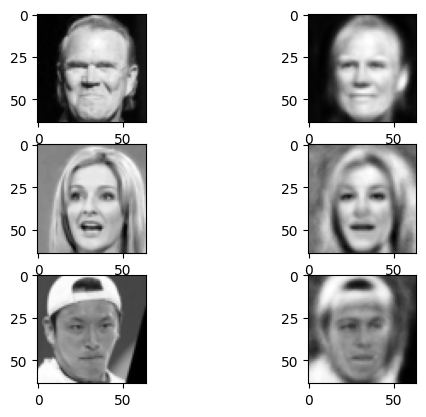

0it [00:00, ?it/s]

In [81]:
#!L
# Train our autoencoder

epochs = 5
outputs = []
losses_train = []
losses_val = []
for epoch in tqdm(range(epochs)):
    for iteration, (image, _) in tqdm(enumerate(train_loader)):

      reconstruction, latent_code = autoencoder(image.to(device))

      loss = criterion(reconstruction, image.reshape(-1,64*64).to(device))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      losses_train.append(loss.cpu().detach().item())

      if (iteration + 1)% 100 == 0:
          print(epoch)
          display.clear_output(wait=True)

          plt.xlabel('Iterations')
          plt.ylabel('MSE')
          plt.title('Loss train')
          plt.plot(range(len(losses_train)), losses_train)
          plt.show()

          if epoch != 0:
            plt.xlabel('Iterations')
            plt.ylabel('MSE')
            plt.title('Loss val')
            plt.plot(range(len(losses_val)), losses_val)
            plt.show()

            reconstruction, latent_code = autoencoder(image_val.to(device))
            reconstruction = reconstruction.data.cpu().numpy().reshape(27,1,64,64).transpose([0, 2, 3, 1])
            nrow = 3
            for i in range(nrow * 2):
                plt.subplot(nrow, 2, i+1)
                if i % 2 != 0:
                  plt.imshow(reconstruction[i - 1], cmap="gray")
                else:
                  plt.imshow(image_val.data.cpu().numpy().transpose([0, 2, 3, 1])[i], cmap="gray")
            plt.show()

    for iteration, (image_val, _) in tqdm(enumerate(val_loader)):
      reconstruction, latent_code = autoencoder(image_val.to(device))
      loss = criterion(reconstruction, image_val.reshape(-1,64*64).to(device))
      losses_val.append(loss.cpu().detach().item())


    outputs.append((epochs, image, reconstruction))

Reconstruction is not bad, right?

In [82]:
from google.colab import files
torch.save(autoencoder.state_dict(), 'autoencoder')
files.download('autoencoder')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
autoencoder.load_state_dict(torch.load('autoencoder'))
autoencoder.eval()

Autoencoder(
  (encoder): Sequential(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=4096, out_features=1024, bias=True)
    (act1): ReLU()
    (to_latent_code): Linear(in_features=1024, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (linear): Linear(in_features=128, out_features=1024, bias=True)
    (act1): ReLU()
    (to_image): Linear(in_features=1024, out_features=4096, bias=True)
    (normalize): Sigmoid()
  )
)

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:836: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


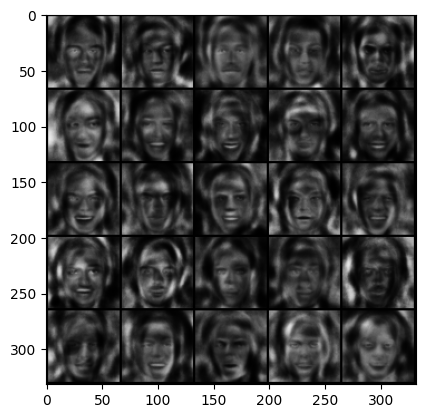

In [14]:
#!L
z = torch.randn(25, dimZ) * 0.5
imgs = autoencoder.decoder(z.to(device)).clamp(0, 1)

plt.imshow(make_grid(imgs.cpu().resize(25, 1, 64, 64), nrow=5).permute(1, 2, 0))

В целом, это очень похоже на лица людей, но проблема в том, что нету деталей (ну либо их очень плохо видно), то есть разнообразие тут слабоватое

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In [16]:
#!L
dimZ = 128

class VAE(nn.Module):

    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(64 * 64, 64 * 16)
        self.fc21 = nn.Linear(64 * 16, dimZ)
        self.fc22 = nn.Linear(64 * 16, dimZ)
        self.fc3 = nn.Linear(dimZ, 64 * 16)
        self.fc4 = nn.Linear(64 * 16, 64 * 64)
        self.relu = nn.ReLU()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def gaussian_sampler(self, mu, logsigma):
        noise = torch.randn_like(mu)
        return noise * logsigma.exp() + mu

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 64 * 64))
        z = self.gaussian_sampler(mu, logvar)
        return self.decode(z), mu, logvar

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z) \to max$$

We will implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_i-x)^2}{2\sigma_i^2}} \Big)=...$$

In [20]:
from torch.nn import functional as F

In [24]:
#!L
def KL_divergence(mu, logsigma):
    return -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())


def log_likelihood(recon_x, x, mu, logsigma):
    return F.binary_cross_entropy(recon_x, x.view(-1, 4096), reduction='sum')


def loss_vae(recon_x, x, mu_z, logsigma_z):
    return KL_divergence(mu_z, logsigma_z) + log_likelihood(recon_x, x, mu_z, logsigma_z)

And train the model:

In [26]:
#!L
criterion = loss_vae

vae = VAE().to(device)

# Use Adam optimizer
optimizer = optim.Adam(vae.parameters())

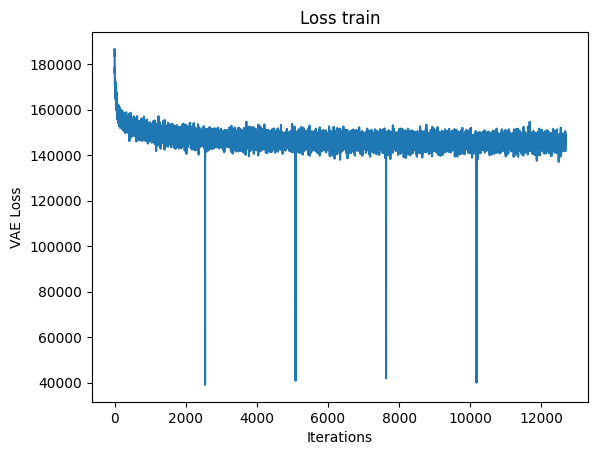

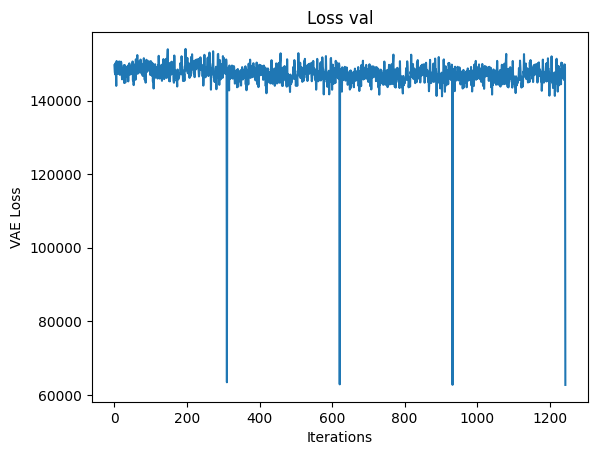

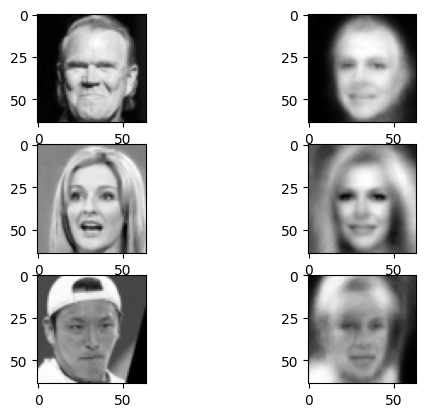

0it [00:00, ?it/s]

In [27]:
#!L
# Train our autoencoder
# Visualize progress in reconstruction and loss decay

epochs = 5
outputs = []
losses_train = []
losses_val = []
for epoch in tqdm(range(epochs)):
    for iteration, (image, _) in tqdm(enumerate(train_loader)):

      reconstruction, mu, log_sigma = vae(image.to(device))

      loss = criterion(reconstruction, image.reshape(-1, 64*64).to(device), mu, log_sigma)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      losses_train.append(loss.cpu().detach().item())

      if (iteration + 1)% 100 == 0:
          print(epoch)
          display.clear_output(wait=True)

          plt.xlabel('Iterations')
          plt.ylabel('VAE Loss')
          plt.title('Loss train')
          plt.plot(range(len(losses_train)), losses_train)
          plt.show()

          if epoch != 0:
            plt.xlabel('Iterations')
            plt.ylabel('VAE Loss')
            plt.title('Loss val')
            plt.plot(range(len(losses_val)), losses_val)
            plt.show()

            reconstruction, mu, log_sigma = vae(image_val.to(device))
            reconstruction = reconstruction.data.cpu().numpy().reshape(27,1,64,64).transpose([0, 2, 3, 1])
            nrow = 3
            for i in range(nrow * 2):
                plt.subplot(nrow, 2, i+1)
                if i % 2 != 0:
                  plt.imshow(reconstruction[i - 1], cmap="gray")
                else:
                  plt.imshow(image_val.data.cpu().numpy().transpose([0, 2, 3, 1])[i], cmap="gray")
            plt.show()

    for iteration, (image_val, _) in tqdm(enumerate(val_loader)):
      reconstruction, mu, log_sigma = vae(image_val.to(device))
      loss = criterion(reconstruction, image_val.reshape(-1,64*64).to(device), mu, log_sigma)
      losses_val.append(loss.cpu().detach().item())


    outputs.append((epochs, image, reconstruction))

Что-то там какие-то стремные значения были раз в эпоху, поэтому построим норм графики, где все хорошо видно

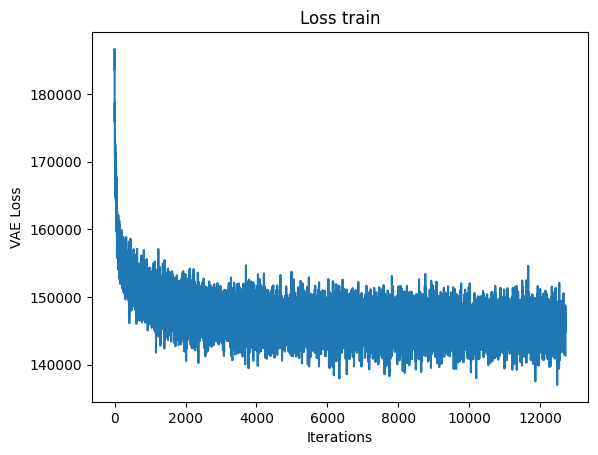

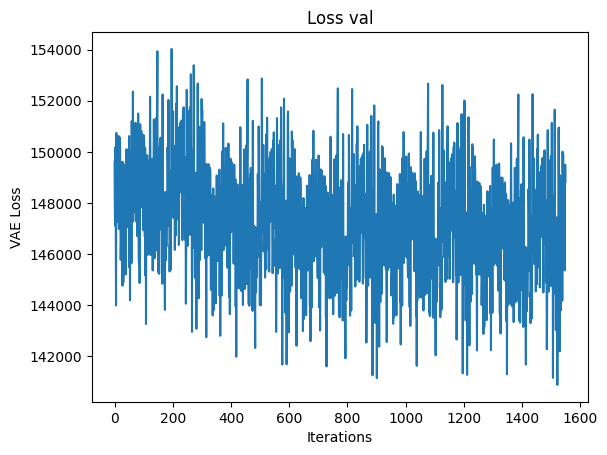

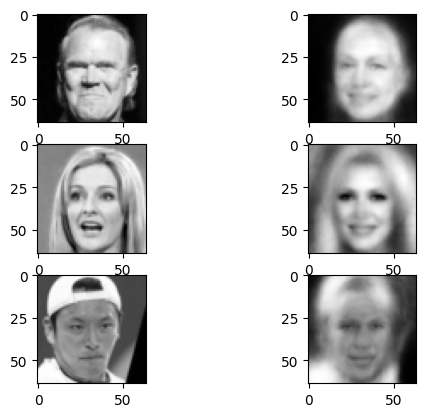

In [29]:
plt.xlabel('Iterations')
plt.ylabel('VAE Loss')
plt.title('Loss train')
losses_train = np.array(losses_train)
losses_train1 = losses_train[losses_train > 80000]
plt.plot(range(len(losses_train1)), losses_train1)
plt.show()

plt.xlabel('Iterations')
plt.ylabel('VAE Loss')
plt.title('Loss val')
losses_val = np.array(losses_val)
losses_val1 = losses_val[losses_val > 80000]
plt.plot(range(len(losses_val1)), losses_val1)
plt.show()

reconstruction, mu, log_sigma = vae(image_val.to(device))
reconstruction = reconstruction.data.cpu().numpy().reshape(27,1,64,64).transpose([0, 2, 3, 1])
nrow = 3
for i in range(nrow * 2):
    plt.subplot(nrow, 2, i+1)
    if i % 2 != 0:
      plt.imshow(reconstruction[i - 1], cmap="gray")
    else:
      plt.imshow(image_val.data.cpu().numpy().transpose([0, 2, 3, 1])[i], cmap="gray")
plt.show()

In [28]:
from google.colab import files
torch.save(vae.state_dict(), 'vae')
files.download('vae')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:836: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


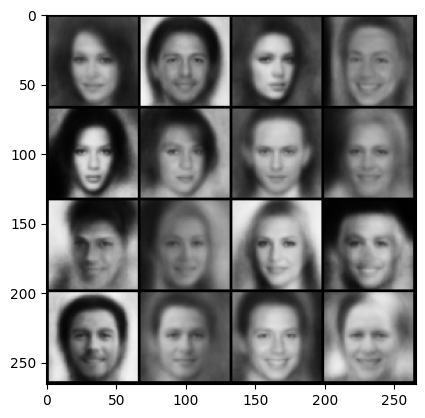

In [32]:
#!L
from itertools import islice
images, _ = list(islice(val_loader, 1))[0]
gen, _, _ = vae(images.to(device))
reconstruction = gen[:16].cpu().clamp(0, 1)

plt.imshow(make_grid(reconstruction.resize(16, 1, 64, 64), nrow=4).permute(1, 2, 0))

Ого, вроде очень классно

And finally sample from VAE.

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:836: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


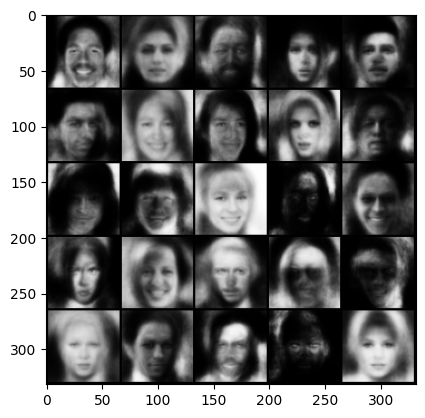

In [40]:
#!L
# Sample some images from the learned distribution
# 1) Sample z ~ N(0,1)
sample = torch.randn(25, dimZ).to(device)
imgs = vae.decode(sample.to(device)).clamp(0, 1)

plt.imshow(make_grid(imgs.cpu().resize(25, 1, 64, 64), nrow=5).permute(1, 2, 0))

Я бы сказал, что тут лучше - более детализированные лица